In [1]:
import os
from pathlib import Path
import sys

# set working directory to the module's home
cwd = os.getcwd()
os.chdir(Path(cwd).parents[0])

In [2]:
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from config import connect
from db_management.database_management import load_data

### Connect to MySQL Database `AQI` for the Table `combined`

In [3]:
conn = connect()
cursor = conn.cursor()

In [4]:
df = load_data(conn, "AQI", "index", "SELECT * FROM AQI.index WHERE state_name='Maryland'")
df.head()

,state_name,date,aqi,category,defining_parameter,latitude,longitude,county_name
0,Maryland,2021-01-01,1,Good,SO2,39.15891,-76.51103,Anne Arundel
1,Maryland,2021-01-02,3,Good,SO2,39.15891,-76.51103,Anne Arundel
2,Maryland,2021-01-03,1,Good,SO2,39.15891,-76.51103,Anne Arundel
3,Maryland,2021-01-04,1,Good,SO2,39.15891,-76.51103,Anne Arundel
4,Maryland,2021-01-05,6,Good,SO2,39.15891,-76.51103,Anne Arundel


In [5]:
df.county_name.unique()

array(['Anne Arundel', 'Baltimore', 'Baltimore (City)', 'Cecil',
       'Dorchester', 'Garrett', 'Harford', 'Howard', 'Kent', 'Montgomery',
       "Prince George's", 'Washington', 'Allegany', 'Frederick',
       'Carroll', 'Charles', 'Calvert'], dtype=object)

In [6]:
mont_df = df[df.county_name=='Montgomery']
mont_df.head()

,state_name,date,aqi,category,defining_parameter,latitude,longitude,county_name
797,Maryland,2021-01-01,48,Good,PM2.5,39.11431,-77.10688,Montgomery
798,Maryland,2021-01-02,20,Good,PM2.5,39.11431,-77.10688,Montgomery
799,Maryland,2021-01-03,28,Good,PM2.5,39.11431,-77.10688,Montgomery
800,Maryland,2021-01-04,30,Good,PM2.5,39.11431,-77.10688,Montgomery
801,Maryland,2021-01-05,34,Good,PM2.5,39.11431,-77.10688,Montgomery


In [7]:
mont_df["date"] = pd.to_datetime(mont_df["date"])

/Users/valerieschnapp/Envs/CSE_6242_Project-cP7jdTvd/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='date'>

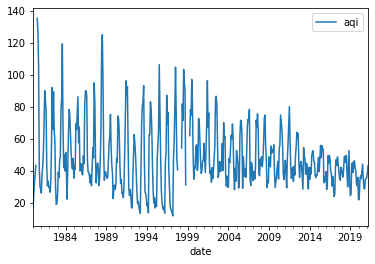

In [28]:
ts_df = mont_df.dropna(subset=["date"]).set_index("date").resample("MS").agg({"aqi":"mean"})
ts_df.plot()

In [29]:
fb_df = ts_df.reset_index().rename(columns={"date":"ds", "aqi":"y"})
fb_df

,ds,y
0,1980-01-01,17.533333
1,1980-02-01,27.000000
2,1980-03-01,33.214286
3,1980-04-01,39.107143
4,1980-05-01,43.400000
...,...,...
490,2020-11-01,34.800000
491,2020-12-01,34.935484
492,2021-01-01,35.483871
493,2021-02-01,38.785714


In [34]:
m = Prophet(seasonality_mode='multiplicative', mcmc_samples=300, weekly_seasonality=False, daily_seasonality=False)
m.fit(fb_df)


Gradient evaluation took 0.000818 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.18 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.001139 seconds
1000 transitions using 10 leapfrog steps per transition would take 11.39 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000988 seconds
1000 transitions using 10 leapfrog steps per transition would take 9.88 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000811 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.11 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 300 [  0%]  (Warmup)
Iteration:   1 / 300 [  0%]  (Warmup)
Iteration:   1 / 300 [  0%]  (Warmup)
Iteration:   1 / 300 [  0%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of th

Iteration:  30 / 300 [ 10%]  (Warmup)
Iteration:  30 / 300 [ 10%]  (Warmup)
Iteration:  30 / 300 [ 10%]  (Warmup)
Iteration:  30 / 300 [ 10%]  (Warmup)
Iteration:  60 / 300 [ 20%]  (Warmup)
Iteration:  60 / 300 [ 20%]  (Warmup)
Iteration:  60 / 300 [ 20%]  (Warmup)
Iteration:  60 / 300 [ 20%]  (Warmup)
Iteration:  90 / 300 [ 30%]  (Warmup)
Iteration:  90 / 300 [ 30%]  (Warmup)
Iteration:  90 / 300 [ 30%]  (Warmup)
Iteration:  90 / 300 [ 30%]  (Warmup)
Iteration: 120 / 300 [ 40%]  (Warmup)
Iteration: 120 / 300 [ 40%]  (Warmup)
Iteration: 120 / 300 [ 40%]  (Warmup)
Iteration: 120 / 300 [ 40%]  (Warmup)
Iteration: 150 / 300 [ 50%]  (Warmup)
Iteration: 151 / 300 [ 50%]  (Sampling)
Iteration: 150 / 300 [ 50%]  (Warmup)
Iteration: 150 / 300 [ 50%]  (Warmup)
Iteration: 151 / 300 [ 50%]  (Sampling)
Iteration: 151 / 300 [ 50%]  (Sampling)
Iteration: 180 / 300 [ 60%]  (Sampling)
Iteration: 150 / 300 [ 50%]  (Warmup)
Iteration: 151 / 300 [ 50%]  (Sampling)
Iteration: 180 / 300 [ 60%]  (Sampling)


/Users/valerieschnapp/Envs/CSE_6242_Project-cP7jdTvd/lib/python3.7/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


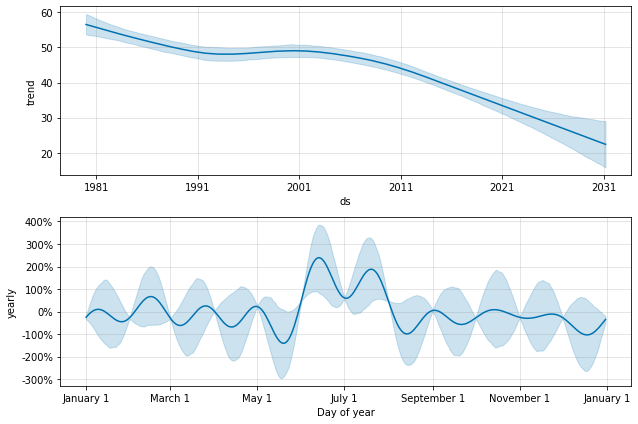

In [35]:
future = m.make_future_dataframe(periods=120, freq="MS")
fcst = m.predict(future)
fig = m.plot_components(fcst)

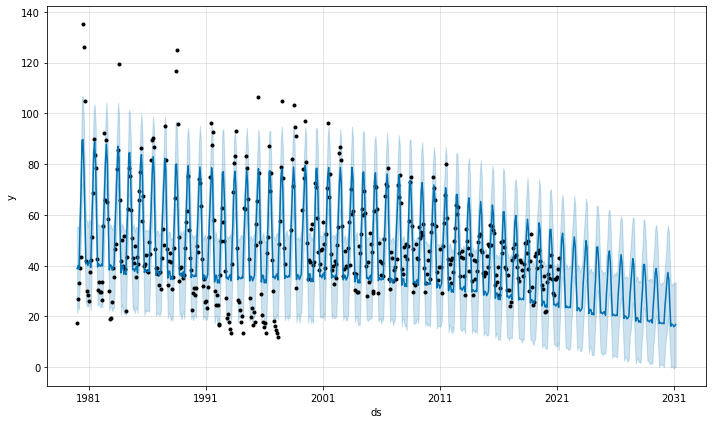

In [36]:
fig = m.plot(fcst)